# Resistive Companion and State Space Nodal simulation approach using DPsim

## General Simulation Procedure

Using the MNA-based C++ solver [DPsim](https://www.fein-aachen.org/en/projects/dpsim/) for power system simulation with the dpsimpy module for python, the simulation is set up and carried out through the following steps:

1)  Import modules
2)  Define simulation parameters: name of the model, simulated time passed between two simulation steps, simulated time at which the simulation stops, time at which the switch closes through an event

3)  Set up circuit nodes
4)  Define circuit components and set their characteristic values
5)  Assemble circuit: Connect components and nodes, set system parameters: frequency, node list, component list
                        
6)  Set up the event which causes the switch to close. A switch event takes a value for the simulated time at which the switch state change
    will occur, the affected switch and if it should open(False) or close(True) when the event triggers

7)  Create simulation instance, set parameters and start the simulation
8)  Plot the results

### Resistive Companion approach: Sample circuit and MNA equations

<img src="/EMT_Ph1_SSN_DufourRLC_RC.png" width="500" align="left">

$V_{vs,peak} = 500kV$, \
$l1 = 0.09803 H$, \
$r1 = 26.07 \Omega$, $l2 = 0.04886 H$, \
$c1 = 0.000001 F$, \
$l\_rlc = 0.01 H$, $c\_rlc = 0.000001 F$, $r\_rlc = 50 \Omega$

Discretization of the defining component equations leads to the following equations which are stamped into the system matrix and vectors:

Resistor MNA (nodal) equation: $I_G(t+\Delta t) = G \cdot U_G(t+\Delta t)$ \
Inductor MNA (nodal) equation: $I(t + \Delta t) = I_L(t) + \frac{\Delta t}{2L}V_L(t) + \frac{\Delta t}{2L}V_L(t+\Delta t)$ \
Capacitor MNA (mesh) equation: $V_C(t + \Delta t) = V_C(t) + \frac{\Delta t}{2C}I_C(t) + \frac{\Delta t}{2C}I_C(t+\Delta t)$

### State Space Nodal approach: Sample circuit and MNA equations

<img src="/EMT_Ph1_SSN_DufourRLC_SSN.png" width="500" align="left">

Additionally to the RC equations above (which are identical to the SSN equations for the basic components R, L and C), the subsystem of a resistor, a capacitor and an inductor which are connected in series to the right of the switch can be merged into one combined component using the SSN approach. The state equations of the subcircuit are:

$\overrightarrow{\dot x} = \begin{bmatrix}
\dot V_C \\
\dot I_{RLC}
\end{bmatrix} =
\begin{bmatrix}
0 & \frac{1}{C} \\
-\frac{1}{L} & -\frac{R}{L} 
\end{bmatrix}
\begin{bmatrix}
V_C \\
I_{RLC}
\end{bmatrix} +
\begin{bmatrix}
0 \\
\frac{1}{L}
\end{bmatrix} \cdot
V_{RLC}$

The lower equation describes the derivative of the current through all three components. After the discretization of both state equations it can be solved for the quantities $V_C(t+\Delta t)$ and $I_{RLC}(t+\Delta t)$ of the current time step. Inserting $V_C(t+\Delta t)$ into the lower equation yields a term for $I_{RLC}(t+\Delta t)$ which is only dependent on previous, known quantities $V_C(t)$, $I_{RLC}(t)$ and the previous voltage $V_{RLC}(t)$ across all three elements as well as $V_{RLC}(t+\Delta t)$, the current voltage across all three elements.

With this, the lower equation is a nodal equation which can be stamped into the system matrix and vectors. To do so, the voltage $V_{RLC}(t+\Delta t)$ has to be identified as node voltages, in this case $V_{RLC}(t+\Delta t) = V_4$. After solving the system for a time step, the state $V_C(t+\Delta t)$ gets updated via the upper state equation. This way, $V_C(t+\Delta t)$, which will be $V_C(t)$ in the next time step, can then be used in the lower equation as a known term again.

$V_{vs,peak} = 500kV$, \
$l1 = 0.09803 H$, \
$r1 = 26.07 \Omega$, $l2 = 0.04886 H$, \
$c1 = 0.000001 F$, \
$l_{rlc} = 0.01 H$, $c_{rlc} = 0.000001 F$, $r_{rlc} = 50 \Omega$

### Simulation: Resistive Companion approach

In [4]:
import villas.dataprocessing.readtools as rt
import matplotlib.pyplot as plt
import sys
sys.path.append("/home/mto/dpsim/build/")
import dpsimpy
#%matplotlib widget


#Simulation parameters
model_name = "EMT_Ph1_DufourRLC"
dpsimpy.Logger.set_log_dir('logs/' + model_name)

time_step = 0.0001          #Passed simulated time between two simulation steps
final_time = 0.1            #Simulation ends when simulated time reaches this value
switch_close_time = 0.05    #Switch closes in the simulation step reaching or exceeding this value of simulated time


# Nodes
gnd = dpsimpy.emt.SimNode.gnd
n1 = dpsimpy.emt.SimNode('n1', dpsimpy.PhaseType.Single)
n2 = dpsimpy.emt.SimNode('n2', dpsimpy.PhaseType.Single)
n3 = dpsimpy.emt.SimNode('n3', dpsimpy.PhaseType.Single)
n4 = dpsimpy.emt.SimNode('n4', dpsimpy.PhaseType.Single)
n5 = dpsimpy.emt.SimNode('n5', dpsimpy.PhaseType.Single)
n6 = dpsimpy.emt.SimNode('n6', dpsimpy.PhaseType.Single)


# Components (RC models)
vs = dpsimpy.emt.ph1.VoltageSource('vs')
vs.set_parameters(V_ref=complex(500000,0), f_src=60)

l1 = dpsimpy.emt.ph1.Inductor('l1')
l1.set_parameters(L = 0.09803)

l2 = dpsimpy.emt.ph1.Inductor('l2')
l2.set_parameters(L = 0.04886)

r1 = dpsimpy.emt.ph1.Resistor('r1')
r1.set_parameters(R = 26.07)

c1 = dpsimpy.emt.ph1.Capacitor('c1')
c1.set_parameters(C=0.000001)

sw = dpsimpy.emt.ph1.Switch('sw')
sw.set_parameters(1e9, 0.00001, False)
sw.open()


#RLC-components: For the RC approach, the RLC-circuit simply consists of a resistor, an inductor and a capacitor. 
#These individual components are RC models.     

r_rlc = dpsimpy.emt.ph1.Resistor('r_rlc')
r_rlc.set_parameters(R=50)
l_rlc = dpsimpy.emt.ph1.Inductor('l_rlc')
l_rlc.set_parameters(L=0.01)
c_rlc = dpsimpy.emt.ph1.Capacitor('c_rlc')
c_rlc.set_parameters(C=0.000001)


# Assemble circuit
vs.connect([gnd, n1])
l1.connect([n2, n1])
l2.connect([n3, n2])
r1.connect([n3, n2])
c1.connect([gnd, n3])
sw.connect([n4, n3])
l_rlc.connect([n5, n4])
c_rlc.connect([n6, n5])
r_rlc.connect([gnd, n6])

system = dpsimpy.SystemTopology(60, [gnd, n1, n2, n3, n4, n5, n6], [vs, l1, l2, r1, c1, sw, r_rlc, l_rlc, c_rlc]) #Parameters are: (frequency=60Hz, system nodes, system components)


#Logging
logger = dpsimpy.Logger(model_name)
logger.log_attribute('v3', 'v', n3)             #log voltage at node 3
logger.log_attribute('i_rlc', 'i_intf', l_rlc)  #log current through RLC branch, inductor current arbitrarily chosen here (equal to resistor and capacitor current) 
logger.log_attribute('i_c1', 'i_intf', c1)      #log current through capacitor c1


#Events
sw_event = dpsimpy.event.SwitchEvent(switch_close_time, sw, True)   #Define event which changes the switch state
                                                                    #Parameters: 
                                                                    #(Simulated time value for which the event activates, affected switch, open[False] or close[True] the switch)


#Simulation
sim = dpsimpy.Simulation(model_name, dpsimpy.LogLevel.debug)
sim.set_system(system)
sim.set_time_step(time_step)
sim.set_final_time(final_time)
sim.set_domain(dpsimpy.Domain.EMT)
sim.set_direct_solver_implementation(dpsimpy.DirectLinearSolverImpl.SparseLU)
sim.do_init_from_nodes_and_terminals(False)
sim.add_logger(logger)
sim.add_event(sw_event)
sim.run()

[16:42:01.768273 EMT_Ph1_DufourRLC info] Initialize simulation: EMT_Ph1_DufourRLC
[16:42:01.768498 MnaSolverFactory info] creating SparseLUAdapter solver implementation
[16:42:01.770242 EMT_Ph1_DufourRLC info] Scheduling tasks.
[16:42:01.770712 EMT_Ph1_DufourRLC info] Scheduling done.
[16:42:01.770715 EMT_Ph1_DufourRLC info] Opening interfaces.
[16:42:01.770717 EMT_Ph1_DufourRLC info] Start synchronization with remotes on interfaces
[16:42:01.770719 EMT_Ph1_DufourRLC info] Synchronized simulation start with remotes
[16:42:01.770721 EMT_Ph1_DufourRLC info] Start simulation: EMT_Ph1_DufourRLC
[16:42:01.770725 EMT_Ph1_DufourRLC info] Time step: 1.000000e-04
[16:42:01.770727 EMT_Ph1_DufourRLC info] Final time: 1.000000e-01
[16:42:01.849697 EMT_Ph1_DufourRLC info] Simulation calculation time: 0.078955
[16:42:01.849745 EMT_Ph1_DufourRLC info] Simulation finished.


5.000000e-02: Handle event time


### Read and plot results of the full RC simulation approach

logs/EMT_Ph1_DufourRLC/EMT_Ph1_DufourRLC.csv
column number: 3
results length: 1000
real column names: ['i_c1', 'i_rlc', 'v3']
complex column names: []


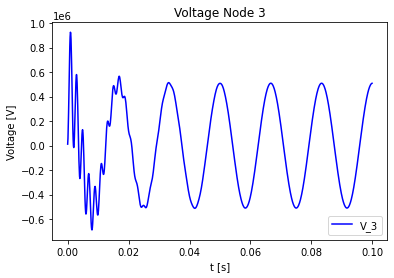

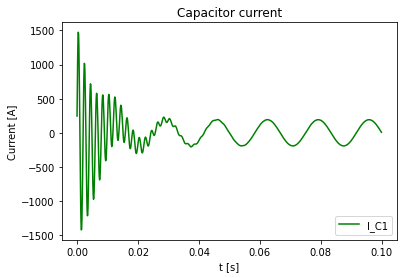

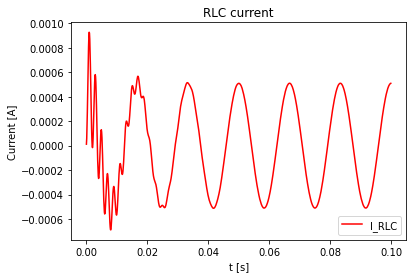

In [5]:
#Read Results
work_dir = 'logs/EMT_Ph1_DufourRLC/'
log_name = 'EMT_Ph1_DufourRLC'
print(work_dir + log_name + '.csv')
ts_emt_ph1_dufour_rlc = rt.read_timeseries_dpsim(work_dir + log_name + '.csv')

#Plot Results
plt.close('all')
fig1 = plt.figure()
plt.plot(ts_emt_ph1_dufour_rlc['v3'].time, ts_emt_ph1_dufour_rlc['v3'].values, "b-", label='V_3')
plt.title('Voltage Node 3')
plt.xlabel('t [s]')
plt.ylabel('Voltage [V]')
plt.legend(loc = 4)

fig2 = plt.figure()
plt.plot(ts_emt_ph1_dufour_rlc['i_c1'].time, ts_emt_ph1_dufour_rlc['i_c1'].values, "g-", label='I_C1')
plt.title('Capacitor current')
plt.xlabel('t [s]')
plt.ylabel('Current [A]')
plt.legend(loc = 4)

fig3 = plt.figure()
plt.plot(ts_emt_ph1_dufour_rlc['i_rlc'].time, ts_emt_ph1_dufour_rlc['i_rlc'].values, "r-", label='I_RLC')
plt.title('RLC current')
plt.xlabel('t [s]')
plt.ylabel('Current [A]')
plt.legend(loc = 4)

### Simulation: State Space Nodal approach

In [6]:
#Simulation parameters
model_name_SSN = "EMT_Ph1_DufourRLC_SSN"
dpsimpy.Logger.set_log_dir('logs/' + model_name_SSN)

time_step = 0.0001          #Passed simulated time between two simulation steps
final_time = 0.1            #Simulation ends when simulated time reaches this value
switch_close_time = 0.05    #Switch closes in the simulation step reaching or exceeding this value of simulated time


# Nodes
gnd = dpsimpy.emt.SimNode.gnd
n1 = dpsimpy.emt.SimNode('n1', dpsimpy.PhaseType.Single)
n2 = dpsimpy.emt.SimNode('n2', dpsimpy.PhaseType.Single)
n3 = dpsimpy.emt.SimNode('n3', dpsimpy.PhaseType.Single)
n4 = dpsimpy.emt.SimNode('n4', dpsimpy.PhaseType.Single)


# Components (RC models)
vs = dpsimpy.emt.ph1.VoltageSource('vs')
vs.set_parameters(V_ref=complex(500000,0), f_src=60)

l1 = dpsimpy.emt.ph1.Inductor('l1')
l1.set_parameters(L = 0.09803)

l2 = dpsimpy.emt.ph1.Inductor('l2')
l2.set_parameters(L = 0.04886)

r1 = dpsimpy.emt.ph1.Resistor('r1')
r1.set_parameters(R = 26.07)

c1 = dpsimpy.emt.ph1.Capacitor('c1')
c1.set_parameters(C=0.000001)

sw = dpsimpy.emt.ph1.Switch('sw')
sw.set_parameters(1e9, 0.001, False)
sw.open()


#RLC components: In the SSN approach, more complex circuits are combined into a single component. 
#Instead of a resistor, an inductor and a capacitor a single SSN RLC element is used.

rlc = dpsimpy.emt.ph1.Full_Serial_RLC('rlc')
rlc.set_parameters(R=50, L=0.01, C=0.000001)


# Assemble circuit
vs.connect([gnd, n1])
l1.connect([n2, n1])
l2.connect([n3, n2])
r1.connect([n3, n2])
c1.connect([gnd, n3])
sw.connect([n4, n3])
rlc.connect([gnd, n4])

system = dpsimpy.SystemTopology(60, [gnd, n1, n2, n3, n4], [vs, l1, l2, r1, c1, sw, rlc])   #Parameters are: (frequency=60Hz, system nodes, system components)


#Logging
loggerSSN = dpsimpy.Logger(model_name_SSN)
loggerSSN.log_attribute('v3', 'v', n3)          #log voltage at node 3
loggerSSN.log_attribute('i_rlc', 'i_intf', rlc) #log current through RLC branch, inductor current arbitrarily chosen here (equal to resistor and capacitor current) 
loggerSSN.log_attribute('i_c1', 'i_intf', c1)   #log current through capacitor c1


#Events
sw_event = dpsimpy.event.SwitchEvent(switch_close_time, sw, True)   #Define event which changes the switch state
                                                                    #Parameters: 
                                                                    #(Simulated time value for which the event activates, affected switch, open[False] or close[True] the switch)


#Simulation
sim = dpsimpy.Simulation(model_name_SSN, dpsimpy.LogLevel.debug)
sim.set_system(system)
sim.set_time_step(time_step)
sim.set_final_time(final_time)
sim.set_domain(dpsimpy.Domain.EMT)
sim.set_direct_solver_implementation(dpsimpy.DirectLinearSolverImpl.SparseLU)
sim.do_init_from_nodes_and_terminals(False)
sim.add_logger(loggerSSN)
sim.add_event(sw_event)
sim.run()

AttributeError: 'dpsimpy.Simulation' object has no attribute 'set_mna_solver_implementation'

### Read results and compare plots of full RC and SSN simulation approaches

In [ ]:
#Read Results
work_dir_SSN = 'logs/EMT_Ph1_DufourRLC_SSN/'
log_name_SSN = 'EMT_Ph1_DufourRLC_SSN'
print(work_dir_SSN + log_name_SSN + '.csv')
ts_emt_ph1_dufour_rlc_ssn = rt.read_timeseries_dpsim(work_dir_SSN + log_name_SSN + '.csv')

#Plot Results
fig3 = plt.figure()
plt.plot(ts_emt_ph1_dufour_rlc['v3'].time, ts_emt_ph1_dufour_rlc['v3'].values, "b-", label='V_3')
plt.plot(ts_emt_ph1_dufour_rlc_ssn['v3'].time, ts_emt_ph1_dufour_rlc_ssn['v3'].values, "c--", label='V_3_SSN')
plt.title('Voltages Node 3')
plt.xlabel('t [s]')
plt.ylabel('Voltages [V]')
plt.legend(loc = 4)

fig4 = plt.figure()
plt.plot(ts_emt_ph1_dufour_rlc['i_c1'].time, ts_emt_ph1_dufour_rlc['i_c1'].values, "m-", label='I_C1')
plt.plot(ts_emt_ph1_dufour_rlc_ssn['i_c1'].time, ts_emt_ph1_dufour_rlc_ssn['i_c1'].values, "y--", label='I_C1_SSN')
plt.title('Capacitor currents')
plt.xlabel('t [s]')
plt.ylabel('Currents [A]')
plt.legend(loc = 4)

fig4 = plt.figure()
plt.plot(ts_emt_ph1_dufour_rlc['i_rlc'].time, ts_emt_ph1_dufour_rlc['i_rlc'].values, "m-", label='I_RLC')
plt.plot(ts_emt_ph1_dufour_rlc_ssn['i_rlc'].time, ts_emt_ph1_dufour_rlc_ssn['i_rlc'].values, "y--", label='I_RLC_SSN')
plt.title('RLC currents')
plt.xlabel('t [s]')
plt.ylabel('Currents [A]')
plt.legend(loc = 4)

